# Libraries import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# Pre-Processing Function

In [3]:
def chooseAndDummifyVariables(df, features_columns, to_dummify, target) :
    X = df[features_columns]
    X = pd.get_dummies(X, columns=to_dummify)
    y = df[target]
    
    return X,y

# Model Train and Score Function

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt
from inspect import signature

In [5]:
def trainAndScore(model, X, y):
    liste_test_size = [a/20.0 for a in range(0,20)][1:]
    scores = []
    rmses = []
    for ts in liste_test_size :
        
        #Spliting the Data into Train and Test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ts, random_state=0)
        
        #Fiting the model
        classifier = model.fit(X_train, y_train)        
                
        #Scoring the model
        score = classifier.score(X_test, y_test)
        scores.append(score)
        
    print("[INFO] SCORES : ",scores)
    print("[INFO] MEAN = ",np.array(scores).mean())
    print("[INFO] MAX = ",max(scores))

In [6]:
def trainAndScorePrecisionRecall(model, X, y):
    liste_test_size = [a/20.0 for a in range(0,20)][1:]
    scores = []
    rmses = []
    for ts in liste_test_size :
        
        #Spliting the Data into Train and Test
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = ts, random_state=0)
        
        #Fiting the model
        classifier = model.fit(X_train, y_train)        
                
        #Scoring the model
        score = classifier.score(X_test, y_test)
        scores.append(score)
        
        computePrecisionRecall(classifier, X_test, y_test)
        
    print("[INFO] SCORES : ",scores)
    print("[INFO] MEAN = ",np.array(scores).mean())
    print("[INFO] MAX = ",max(scores))
    
    return classifier, X_test, y_test

In [7]:
def computePrecisionRecall(classifier, X_test, y_test): 
    
    y_score = classifier.decision_function(X_test)
    average_precision = average_precision_score(y_test, y_score)
    precision, recall, _ = precision_recall_curve(y_test, y_score)

    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
                   if 'step' in signature(plt.fill_between).parameters
                   else {})
    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))
    plt.show()

# Importing the Data

In [8]:
df = pd.read_csv('african_crises.csv', sep=';')

In [9]:
df.head()

,country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,Algeria,1870,1,0.052264,0,0,0.0,3.441456,0,0,0,crisis
1,Algeria,1871,0,0.052798,0,0,0.0,14.149140,0,0,0,no_crisis
2,Algeria,1872,0,0.052274,0,0,0.0,-3.718593,0,0,0,no_crisis
3,Algeria,1873,0,0.051680,0,0,0.0,11.203897,0,0,0,no_crisis
4,Algeria,1874,0,0.051308,0,0,0.0,-3.848561,0,0,0,no_crisis


### Inventory of explanatory variables in the data

In [10]:
df.shape

(1059, 12)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023D673B1080>,
      dtype=object)

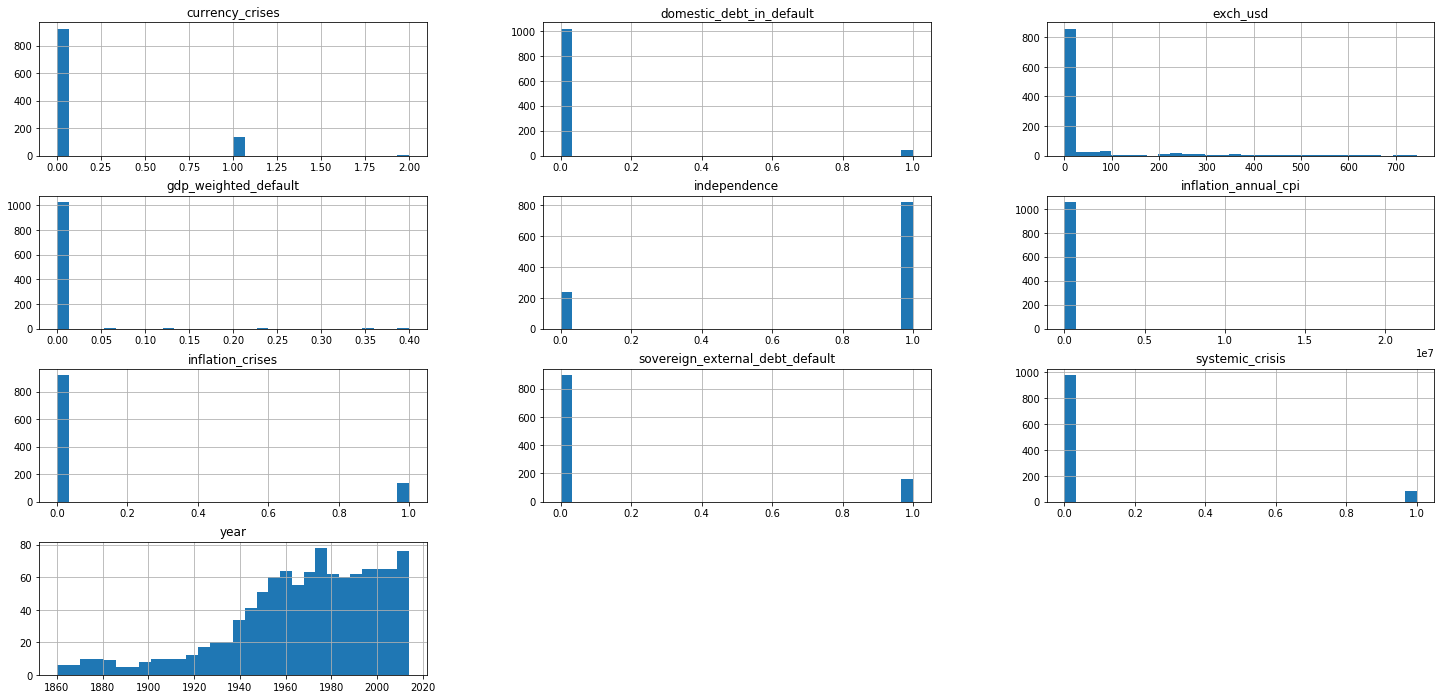

In [11]:
df.hist(bins=30, figsize=(25,12))

### 3 different models that can be used for the this Classification problem

1. Logistic Regression
2. Random Forest Classifier
3. K-Nearest Neighbors

### Replace country column with area codes

In [12]:
df.columns

Index(['country', 'year', 'systemic_crisis', 'exch_usd',
       'domestic_debt_in_default', 'sovereign_external_debt_default',
       'gdp_weighted_default', 'inflation_annual_cpi', 'independence',
       'currency_crises', 'inflation_crises', 'banking_crisis'],
      dtype='object')

In [13]:
df['country'].unique()

array(['Algeria', 'Angola', 'Central African Republic', 'Ivory Coast',
       'Egypt', 'Kenya', 'Mauritius', 'Morocco', 'Nigeria',
       'South Africa', 'Tunisia', 'Zambia', 'Zimbabwe'], dtype=object)

In [14]:
df['country']

0        Algeria
1        Algeria
2        Algeria
3        Algeria
4        Algeria
          ...   
1054    Zimbabwe
1055    Zimbabwe
1056    Zimbabwe
1057    Zimbabwe
1058    Zimbabwe
Name: country, Length: 1059, dtype: object

In [15]:
df['country'] = df['country'].apply(lambda x : x[:2].upper() )

In [16]:
df['country'].unique()

array(['AL', 'AN', 'CE', 'IV', 'EG', 'KE', 'MA', 'MO', 'NI', 'SO', 'TU',
       'ZA', 'ZI'], dtype=object)

In [17]:
df.isna().sum()

country                            0
year                               0
systemic_crisis                    0
exch_usd                           0
domestic_debt_in_default           0
sovereign_external_debt_default    0
gdp_weighted_default               0
inflation_annual_cpi               0
independence                       0
currency_crises                    0
inflation_crises                   0
banking_crisis                     0
dtype: int64

### The proportion of crisis years for each country

In [18]:
def calculatePaysCrisesProportion(df) : 
    pays = df['country'].unique()
    occurences = []
    
    for p in pays :
        chunk = df[df['country'] == p]
        occurence = chunk.shape[0]
        occurences.append((p,occurence))
    
    #print('-- [INFO] -- FREQUENCES')
    #print(occurences)
    
    proportions = []
    cpt = 0
    for pays, occurence in occurences :
        proportion = occurence / df.shape[0]  # proportion of the number of crisis of the country
        cpt+=proportion
        proportions.append((pays,proportion))

    print('-- [INFO] -- PROPORTIONS')
    print(proportions)
    
    #print(cpt) to verify that the sum of the proportions equals to 1

In [19]:
calculatePaysCrisesProportion(df)

-- [INFO] -- PROPORTIONS
[('AL', 0.08026440037771483), ('AN', 0.07271010387157696), ('CE', 0.05476864966949953), ('IV', 0.059490084985835696), ('EG', 0.14636449480642116), ('KE', 0.06326723323890462), ('MA', 0.06421152030217187), ('MO', 0.0708215297450425), ('NI', 0.056657223796033995), ('SO', 0.10764872521246459), ('TU', 0.0708215297450425), ('ZA', 0.0679886685552408), ('ZI', 0.08498583569405099)]


### Data Preparation for the Model

In [20]:
def cris(x):
    if x == 'crisis' :
        return 1
    return 0

In [21]:
df['banking_crisis'] = df['banking_crisis'].apply(lambda x : cris(x))

In [22]:
df.head()

,country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
0,AL,1870,1,0.052264,0,0,0.0,3.441456,0,0,0,1
1,AL,1871,0,0.052798,0,0,0.0,14.149140,0,0,0,0
2,AL,1872,0,0.052274,0,0,0.0,-3.718593,0,0,0,0
3,AL,1873,0,0.051680,0,0,0.0,11.203897,0,0,0,0
4,AL,1874,0,0.051308,0,0,0.0,-3.848561,0,0,0,0


In [23]:
df.dtypes

country                             object
year                                 int64
systemic_crisis                      int64
exch_usd                           float64
domestic_debt_in_default             int64
sovereign_external_debt_default      int64
gdp_weighted_default               float64
inflation_annual_cpi               float64
independence                         int64
currency_crises                      int64
inflation_crises                     int64
banking_crisis                       int64
dtype: object

> We have a Categorical variable which is the variable COUNTRY

In [24]:
features_columns = ['country', 'systemic_crisis', 'exch_usd', 'domestic_debt_in_default', 'sovereign_external_debt_default', 
                    'gdp_weighted_default', 'independence', 'currency_crises', 'inflation_crises' ]
to_dummify = ['country']
target  = 'banking_crisis'

In [25]:
X , y = chooseAndDummifyVariables(df, features_columns, to_dummify, target )

In [26]:
X.columns

Index(['systemic_crisis', 'exch_usd', 'domestic_debt_in_default',
       'sovereign_external_debt_default', 'gdp_weighted_default',
       'independence', 'currency_crises', 'inflation_crises', 'country_AL',
       'country_AN', 'country_CE', 'country_EG', 'country_IV', 'country_KE',
       'country_MA', 'country_MO', 'country_NI', 'country_SO', 'country_TU',
       'country_ZA', 'country_ZI'],
      dtype='object')

In [27]:
X

,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,independence,currency_crises,inflation_crises,country_AL,country_AN,...,country_EG,country_IV,country_KE,country_MA,country_MO,country_NI,country_SO,country_TU,country_ZA,country_ZI
0,1,0.052264,0,0,0.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0.052798,0,0,0.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.052274,0,0,0.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0.051680,0,0,0.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0.051308,0,0,0.0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,1,354.800000,1,1,0.0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1055,0,378.200000,1,1,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1056,0,361.900000,1,1,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1057,0,361.900000,1,1,0.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


# Model build

## Logistic Regression  - Précision et Rappel

In [28]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
trainAndScore(model, X, y)

[INFO] SCORES :  [0.9433962264150944, 0.9528301886792453, 0.9685534591194969, 0.9716981132075472, 0.9660377358490566, 0.9685534591194969, 0.9730458221024259, 0.9716981132075472, 0.9685534591194969, 0.969811320754717, 0.9725557461406518, 0.9732704402515723, 0.9753265602322206, 0.9663072776280324, 0.9534591194968554, 0.9563679245283019, 0.9445061043285239, 0.9046121593291404, 0.9185700099304865]
[INFO] MEAN =  0.9589028020757848
[INFO] MAX =  0.9753265602322206


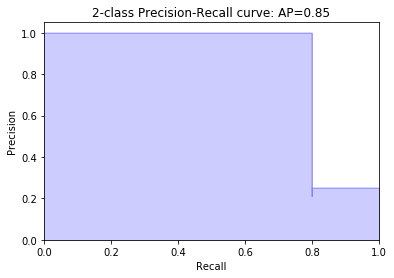

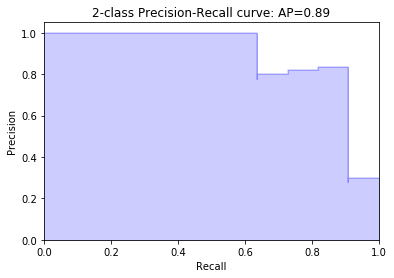

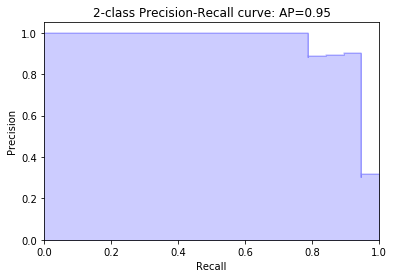

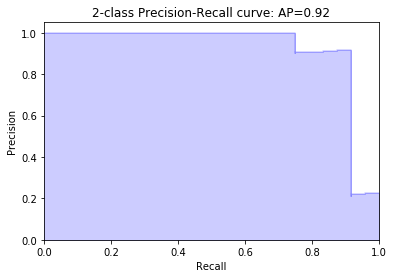

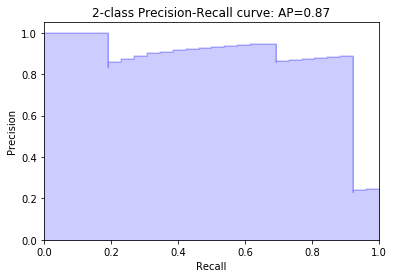

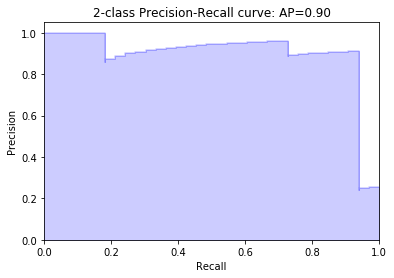

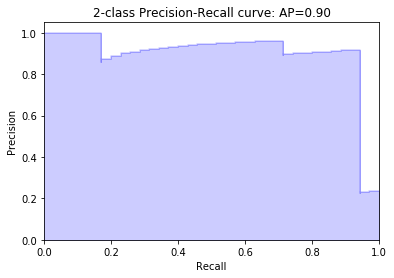

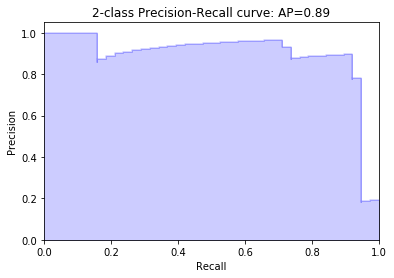

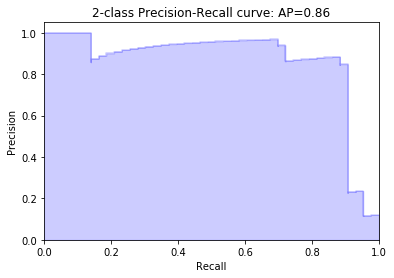

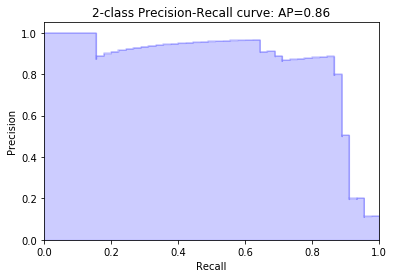

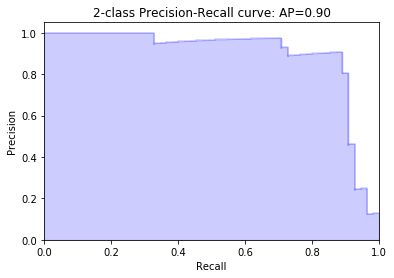

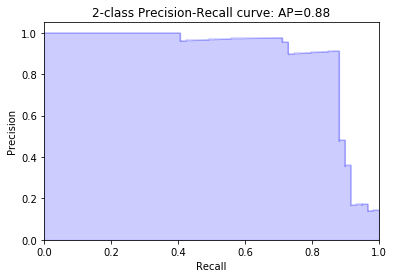

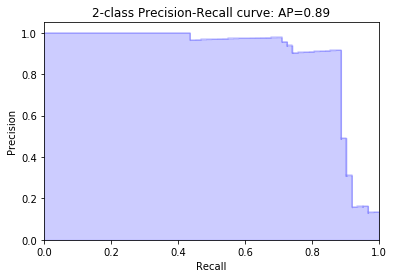

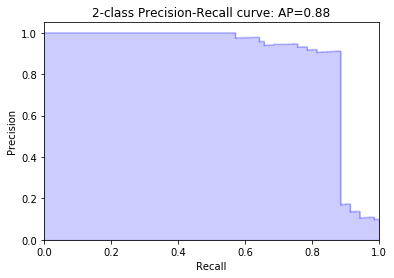

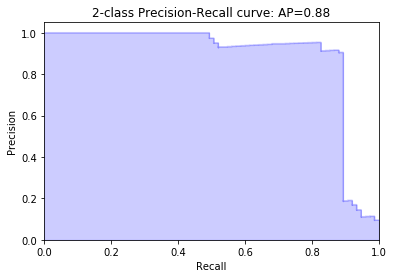

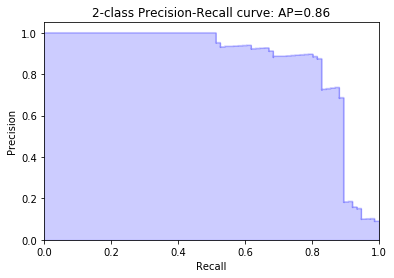

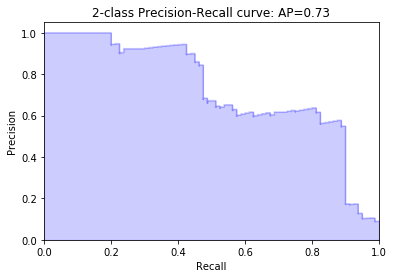

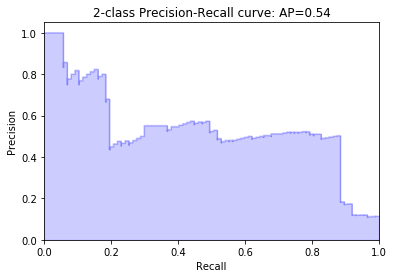

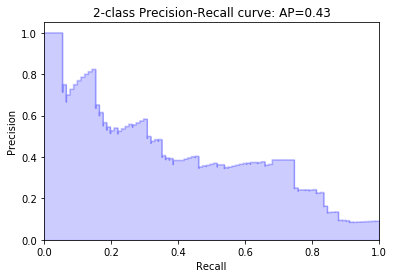

[INFO] SCORES :  [0.9433962264150944, 0.9528301886792453, 0.9685534591194969, 0.9716981132075472, 0.9660377358490566, 0.9685534591194969, 0.9730458221024259, 0.9716981132075472, 0.9685534591194969, 0.969811320754717, 0.9725557461406518, 0.9732704402515723, 0.9753265602322206, 0.9663072776280324, 0.9534591194968554, 0.9563679245283019, 0.9445061043285239, 0.9046121593291404, 0.9185700099304865]
[INFO] MEAN =  0.9589028020757848
[INFO] MAX =  0.9753265602322206


(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False),
      systemic_crisis    exch_usd  domestic_debt_in_default  \
 418                0    3.390000                         0   
 202                1  598.809576                         0   
 682                0    5.353319                         0   
 316                0    0.198300                         0   
 267                0    0.000000                         0   
 ..               ...         ...                       ...   
 442                0    7.142800                         0   
 42                 0    4.556000                         0   
 617                1    9.551200                         0   
 388                0    0.434800      

In [29]:
trainAndScorePrecisionRecall(model, X, y)

## SVM

In [30]:
from sklearn.svm import SVC
model = SVC(gamma='auto')
trainAndScore(model, X, y)

[INFO] SCORES :  [0.9433962264150944, 0.9150943396226415, 0.9308176100628931, 0.9245283018867925, 0.9207547169811321, 0.9119496855345912, 0.9272237196765498, 0.9268867924528302, 0.9287211740041929, 0.9283018867924528, 0.9245283018867925, 0.9135220125786163, 0.9100145137880987, 0.9043126684636119, 0.9044025157232705, 0.9080188679245284, 0.9100998890122086, 0.910901467505241, 0.9106256206554121]
[INFO] MEAN =  0.9186368584719448
[INFO] MAX =  0.9433962264150944


## Naive Bayes

In [31]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
trainAndScore(model, X, y)

[INFO] SCORES :  [0.9056603773584906, 0.9433962264150944, 0.8930817610062893, 0.8679245283018868, 0.8339622641509434, 0.8427672955974843, 0.8463611859838275, 0.8443396226415094, 0.8679245283018868, 0.8603773584905661, 0.7564322469982847, 0.7783018867924528, 0.7982583454281568, 0.6563342318059299, 0.5534591194968553, 0.5471698113207547, 0.5893451720310766, 0.6509433962264151, 0.7934458788480635]
[INFO] MEAN =  0.780499223010314
[INFO] MAX =  0.9433962264150944


## Decision Tree

In [32]:
from sklearn import tree
model = tree.DecisionTreeClassifier()
trainAndScore(model, X, y)

[INFO] SCORES :  [0.9622641509433962, 0.9622641509433962, 0.9622641509433962, 0.9716981132075472, 0.9660377358490566, 0.9716981132075472, 0.9730458221024259, 0.9764150943396226, 0.9706498951781971, 0.9660377358490566, 0.9588336192109777, 0.9591194968553459, 0.9521044992743106, 0.9595687331536388, 0.9610062893081761, 0.9622641509433962, 0.9489456159822419, 0.960167714884696, 0.9235352532274081]
[INFO] MEAN =  0.9614694913370441
[INFO] MAX =  0.9764150943396226


## Random Forest Classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 20)
trainAndScore(model, X, y)

[INFO] SCORES :  [0.9622641509433962, 0.9811320754716981, 0.9811320754716981, 0.9811320754716981, 0.9735849056603774, 0.9748427672955975, 0.9784366576819407, 0.9787735849056604, 0.9727463312368972, 0.9754716981132076, 0.9708404802744426, 0.9685534591194969, 0.97677793904209, 0.9649595687331537, 0.9748427672955975, 0.9681603773584906, 0.974472807991121, 0.9538784067085954, 0.913604766633565]
[INFO] MEAN =  0.9697687839688803
[INFO] MAX =  0.9811320754716981


## K-Nearest Neighbors

In [34]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=25) 
trainAndScore(model, X, y)

[INFO] SCORES :  [0.9056603773584906, 0.8962264150943396, 0.8805031446540881, 0.8867924528301887, 0.9018867924528302, 0.8962264150943396, 0.9056603773584906, 0.910377358490566, 0.909853249475891, 0.9150943396226415, 0.9056603773584906, 0.9072327044025157, 0.9100145137880987, 0.9056603773584906, 0.9056603773584906, 0.910377358490566, 0.9112097669256382, 0.9088050314465409, 0.9096325719960278]
[INFO] MEAN =  0.904343894818775
[INFO] MAX =  0.9150943396226415


## Gradient Boosting Classifier - Précision et Rappel

In [35]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=100,max_depth=5)
trainAndScore(model, X, y)

[INFO] SCORES :  [0.9622641509433962, 0.9622641509433962, 0.9685534591194969, 0.9669811320754716, 0.9660377358490566, 0.9716981132075472, 0.9757412398921833, 0.9764150943396226, 0.9706498951781971, 0.9716981132075472, 0.9639794168096055, 0.9591194968553459, 0.9550072568940493, 0.9595687331536388, 0.9622641509433962, 0.9622641509433962, 0.9600443951165372, 0.960167714884696, 0.9275074478649454]
[INFO] MEAN =  0.9632750446432382
[INFO] MAX =  0.9764150943396226


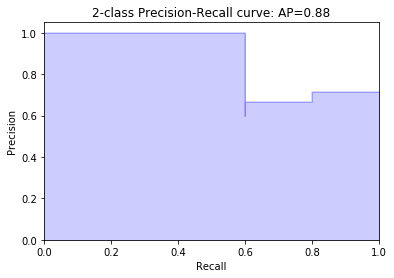

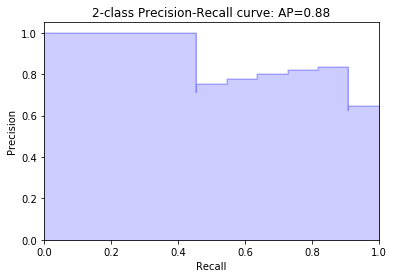

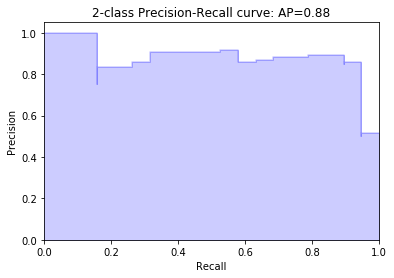

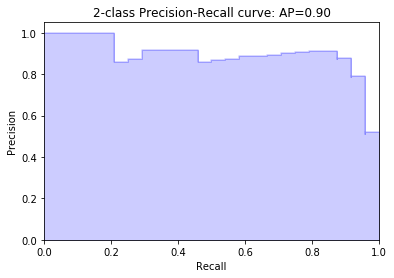

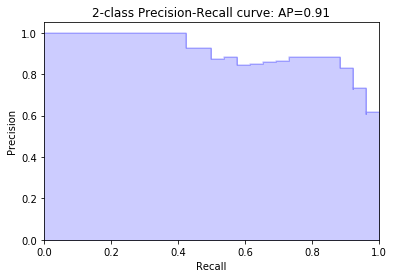

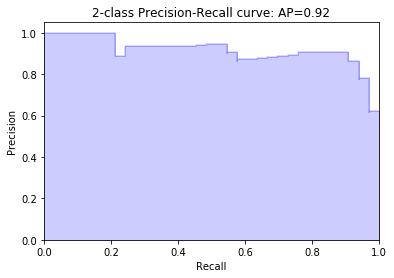

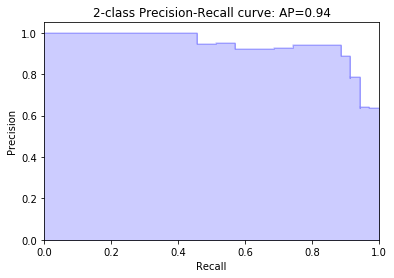

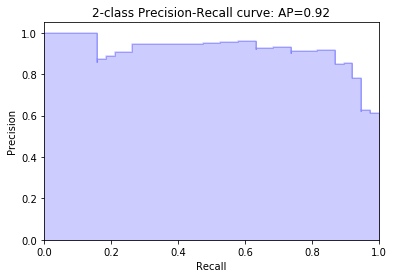

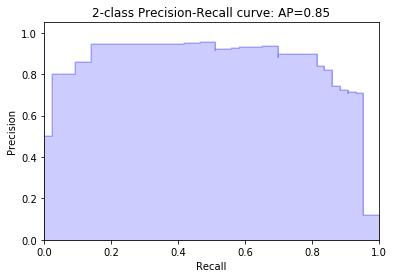

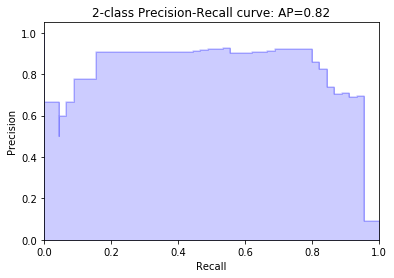

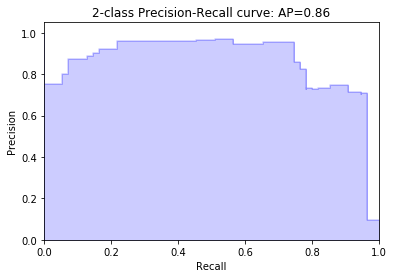

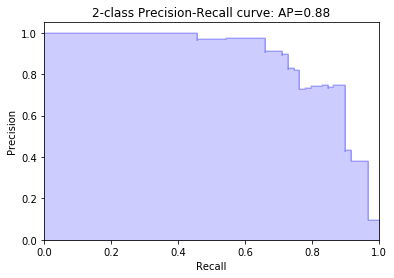

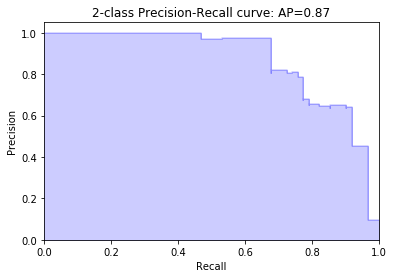

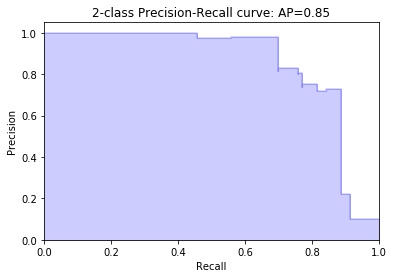

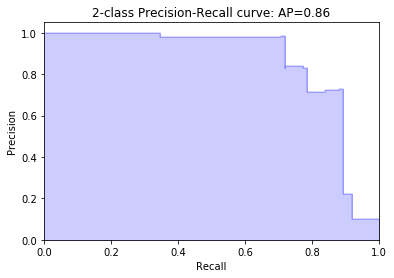

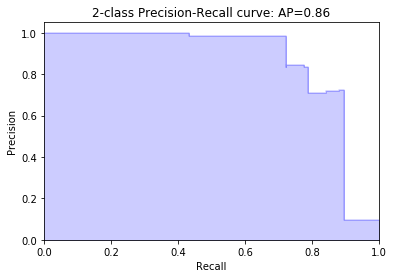

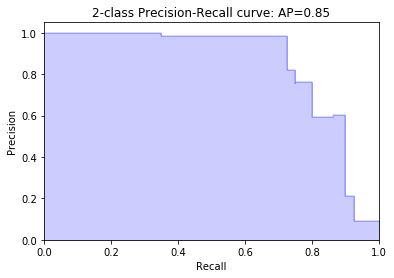

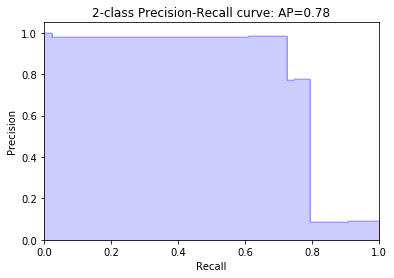

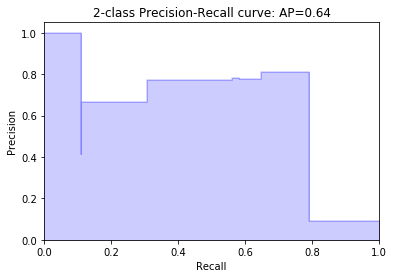

[INFO] SCORES :  [0.9622641509433962, 0.9622641509433962, 0.9685534591194969, 0.9669811320754716, 0.9660377358490566, 0.9716981132075472, 0.9757412398921833, 0.9764150943396226, 0.9706498951781971, 0.9716981132075472, 0.9639794168096055, 0.9591194968553459, 0.95355587808418, 0.9609164420485176, 0.9622641509433962, 0.9622641509433962, 0.9600443951165372, 0.960167714884696, 0.9235352532274081]
[INFO] MEAN =  0.9630605254562631
[INFO] MAX =  0.9764150943396226


(GradientBoostingClassifier(criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=5,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_iter_no_change=None, presort='auto',
                            random_state=None, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False),
      systemic_crisis    exch_usd  domestic_debt_in_default  \
 418                0    3.390000                         0   
 202                1  598.809576                         0   
 682                0    5.353319                         0   
 316                0    0.198300                         0  

In [36]:
trainAndScorePrecisionRecall(model, X, y)

## XGBoost  - Précision et Rappel

In [37]:
from xgboost import XGBClassifier
model = XGBClassifier()
trainAndScore(model, X, y)

[INFO] SCORES :  [0.9433962264150944, 0.9622641509433962, 0.9748427672955975, 0.9716981132075472, 0.9735849056603774, 0.9622641509433962, 0.967654986522911, 0.9716981132075472, 0.9685534591194969, 0.9735849056603774, 0.9759862778730704, 0.9779874213836478, 0.9796806966618288, 0.9824797843665768, 0.9811320754716981, 0.9834905660377359, 0.97669256381798, 0.9779874213836478, 0.9096325719960278]
[INFO] MEAN =  0.9691900609456818
[INFO] MAX =  0.9834905660377359


# UP-Sampling the Data

In [38]:
from sklearn.utils import resample

> After doing a little analysis on our data, we are in a problem of Imbalanced Data. Our algorithm can easily get overfitting

> We then do the up-sampling technique to ensure that our two classes are equi-distributed and that our model is as good as the accuracy is good

In [39]:
cr = df[df['banking_crisis'] == 1]
nocr = df[df['banking_crisis'] == 0]

In [40]:
cr.shape

(94, 12)

In [41]:
nocr.shape

(965, 12)

In [42]:
# Upsample minority class
cr_upsampled = resample(cr, replace=True, n_samples=965,  random_state=123) # reproducible results
 
cr_upsampled

,country,year,systemic_crisis,exch_usd,domestic_debt_in_default,sovereign_external_debt_default,gdp_weighted_default,inflation_annual_cpi,independence,currency_crises,inflation_crises,banking_crisis
707,NI,2014,1,1.552500e+02,0,0,0.0,8.048000e+00,1,0,0,1
1053,ZI,2008,1,2.000000e-03,1,1,0.0,2.198970e+07,1,1,1,1
187,CE,1982,1,3.362498e+02,0,0,0.0,1.324300e+01,1,0,0,1
1044,ZI,1999,1,3.720000e-25,0,0,0.0,5.692320e+01,1,0,1,1
686,NI,1993,1,2.188184e+01,0,1,0.0,5.714300e+01,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
686,NI,1993,1,2.188184e+01,0,1,0.0,5.714300e+01,1,0,1,1
257,IV,1989,1,3.050000e+02,0,1,0.0,9.860000e-01,1,0,0,1
1048,ZI,2003,1,7.950000e-24,1,1,0.0,5.987448e+02,1,1,1,1
185,CE,1980,1,2.257998e+02,0,0,0.0,1.330000e+01,1,0,0,1


In [43]:
cr_upsampled.columns

Index(['country', 'year', 'systemic_crisis', 'exch_usd',
       'domestic_debt_in_default', 'sovereign_external_debt_default',
       'gdp_weighted_default', 'inflation_annual_cpi', 'independence',
       'currency_crises', 'inflation_crises', 'banking_crisis'],
      dtype='object')

In [44]:
df_upsampled = pd.concat([nocr, cr_upsampled])

In [45]:
df_upsampled.shape

(1930, 12)

In [46]:
cr = df_upsampled[df_upsampled['banking_crisis'] == 1]
nocr = df_upsampled[df_upsampled['banking_crisis'] == 0]

In [47]:
cr.shape

(965, 12)

In [48]:
nocr.shape

(965, 12)

In [49]:
features_columns = ['country', 'systemic_crisis', 'exch_usd', 'domestic_debt_in_default', 'sovereign_external_debt_default', 
                    'gdp_weighted_default', 'independence', 'currency_crises', 'inflation_crises' ]
to_dummify = ['country']
target  = 'banking_crisis'
X , y = chooseAndDummifyVariables(df_upsampled, features_columns, to_dummify, target )

## Logistic Regression

In [50]:
model = LogisticRegression()
trainAndScore(model, X, y)

[INFO] SCORES :  [0.9381443298969072, 0.9378238341968912, 0.9172413793103448, 0.9352331606217616, 0.9440993788819876, 0.9430051813471503, 0.9482248520710059, 0.9430051813471503, 0.9470655926352128, 0.9492227979274611, 0.9500941619585688, 0.9525043177892919, 0.949800796812749, 0.9533678756476683, 0.9537292817679558, 0.9540155440414507, 0.9463741620962828, 0.945308002302821, 0.9416575790621592]
[INFO] MEAN =  0.9447324952481485
[INFO] MAX =  0.9540155440414507


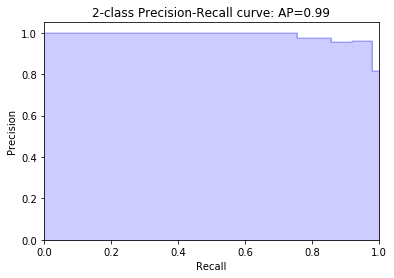

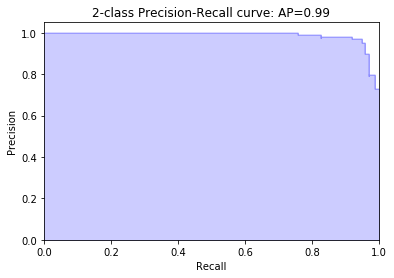

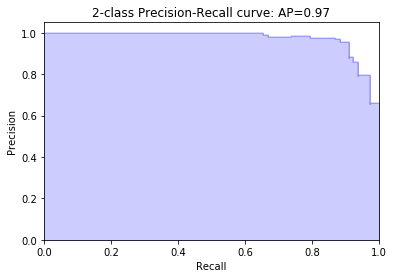

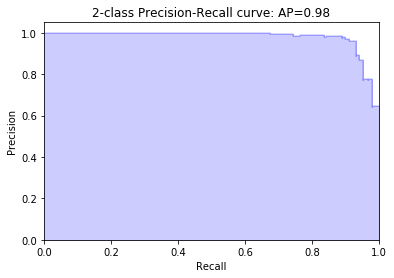

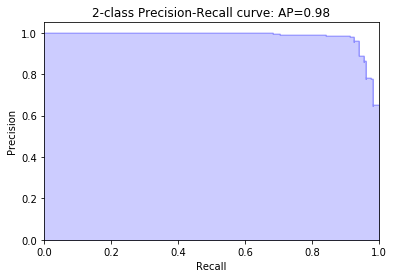

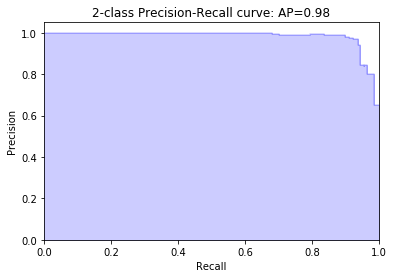

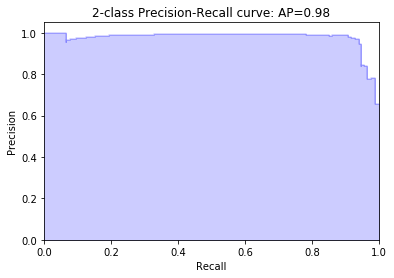

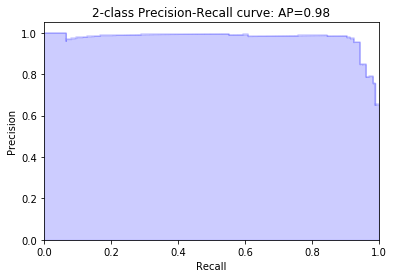

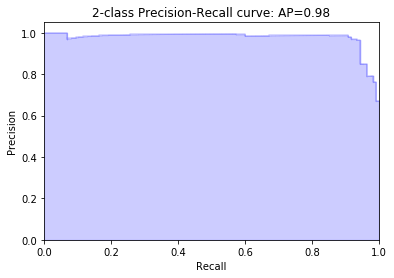

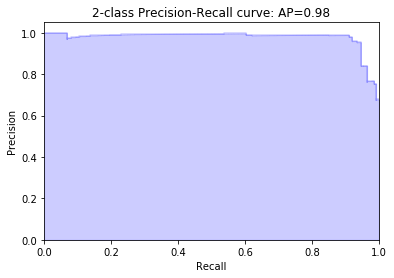

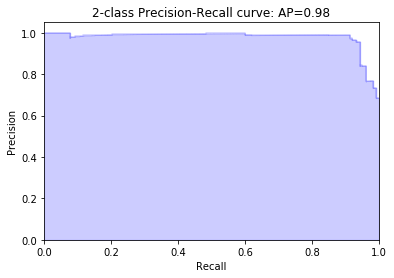

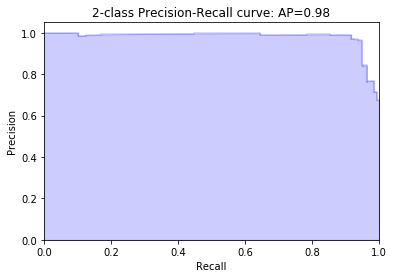

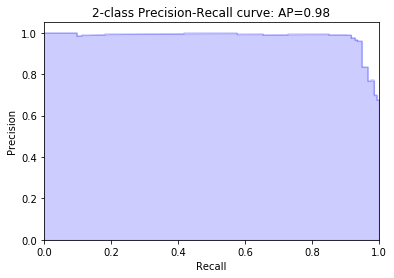

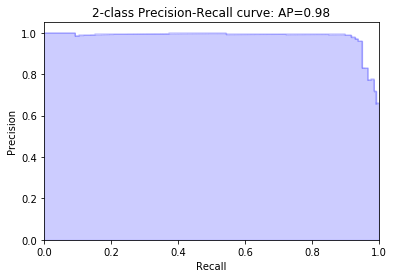

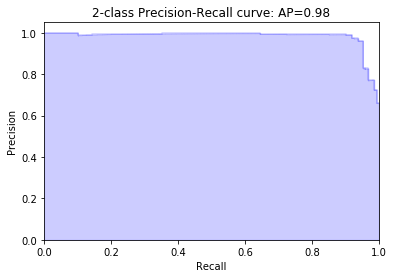

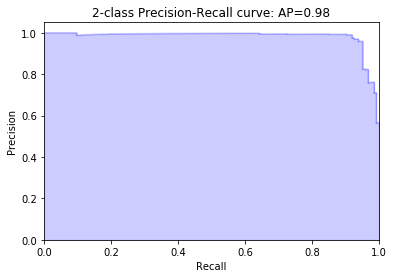

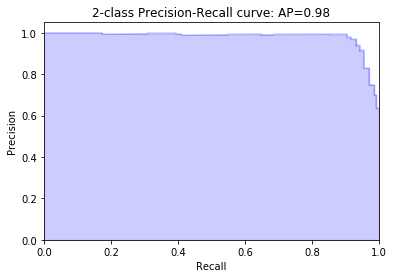

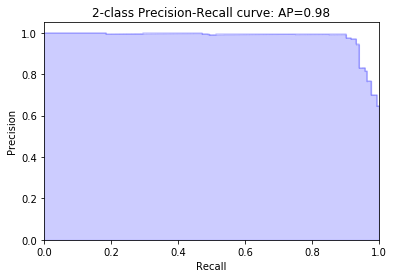

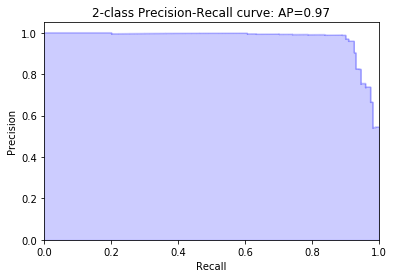

[INFO] SCORES :  [0.9381443298969072, 0.9378238341968912, 0.9172413793103448, 0.9352331606217616, 0.9440993788819876, 0.9430051813471503, 0.9482248520710059, 0.9430051813471503, 0.9470655926352128, 0.9492227979274611, 0.9500941619585688, 0.9525043177892919, 0.949800796812749, 0.9533678756476683, 0.9537292817679558, 0.9540155440414507, 0.9463741620962828, 0.945308002302821, 0.9416575790621592]
[INFO] MEAN =  0.9447324952481485
[INFO] MAX =  0.9540155440414507


(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=None, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False),
       systemic_crisis      exch_usd  domestic_debt_in_default  \
 1036                0  5.040000e-26                         0   
 797                 0  2.536011e+00                         0   
 544                 0  1.313670e+01                         0   
 413                 0  2.000000e+00                         0   
 688                 1  2.188663e+01                         0   
 ...               ...           ...                       ...   
 943                 0  1.841000e-02                         0   
 876                 1  9.912000e-01                         0   
 62                  1  2.278140e+01                         0   
 873     

In [51]:
trainAndScorePrecisionRecall(model, X, y)

## Gradient Boosting Classifier

In [52]:
from sklearn.ensemble import GradientBoostingClassifier
model = GradientBoostingClassifier(n_estimators=100,max_depth=5)
trainAndScore(model, X, y)

[INFO] SCORES :  [0.9896907216494846, 0.9948186528497409, 0.993103448275862, 0.9896373056994818, 0.9937888198757764, 0.9930915371329879, 0.992603550295858, 0.9909326424870466, 0.9919447640966629, 0.9906735751295337, 0.9858757062146892, 0.9861830742659758, 0.9888446215139443, 0.9881569207994079, 0.9861878453038674, 0.9734455958549223, 0.9792809262644728, 0.9643062751871042, 0.9574700109051254]
[INFO] MEAN =  0.9857913680948394
[INFO] MAX =  0.9948186528497409


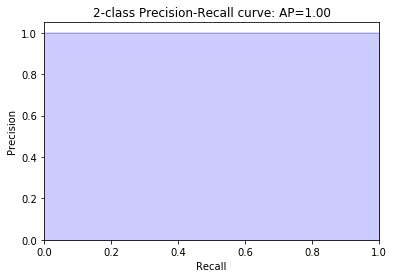

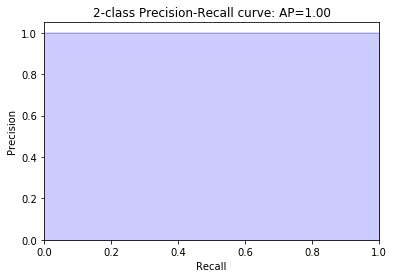

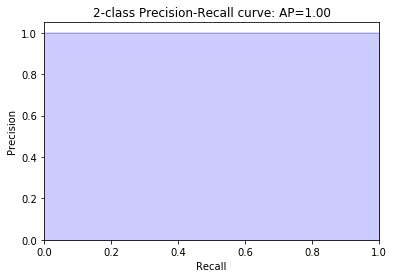

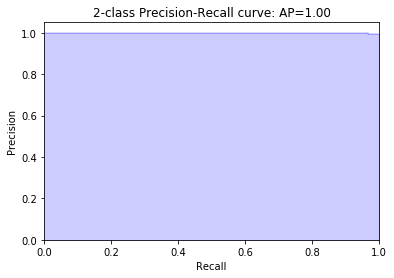

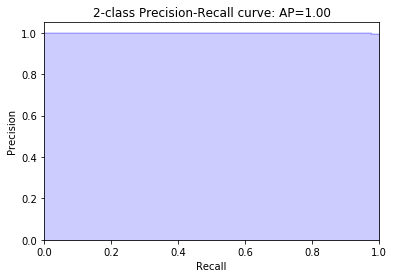

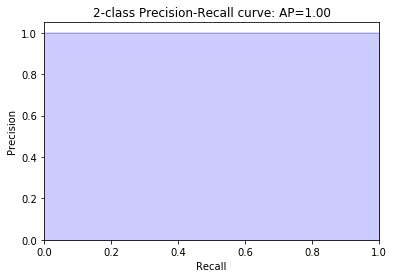

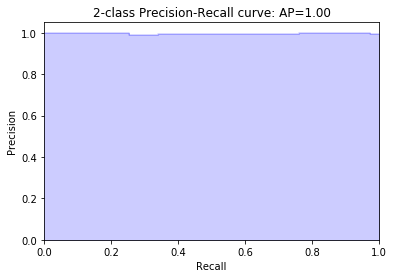

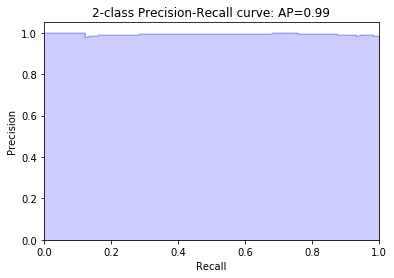

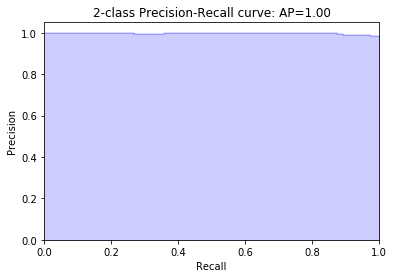

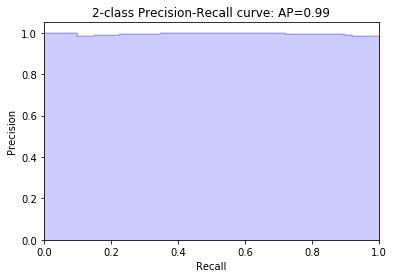

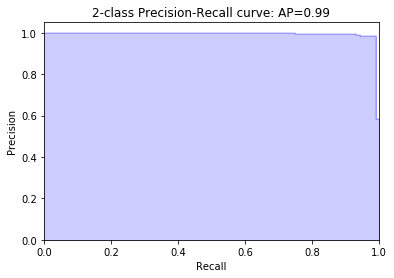

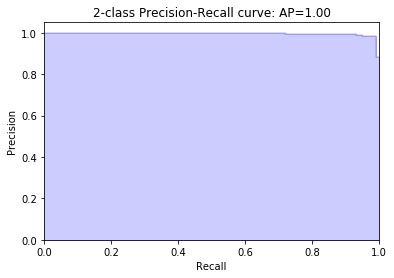

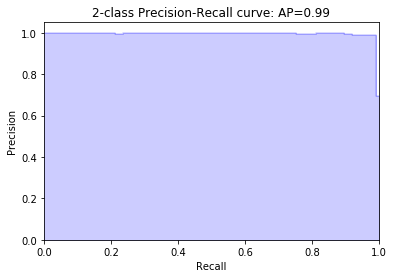

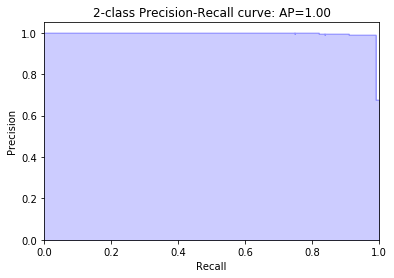

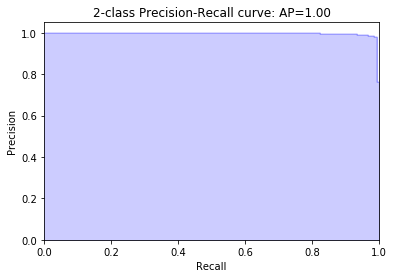

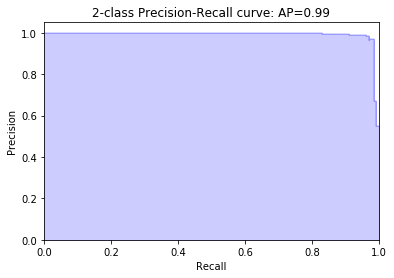

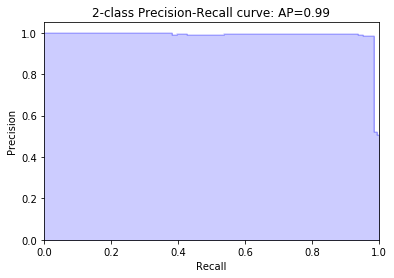

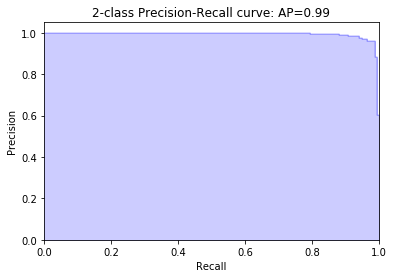

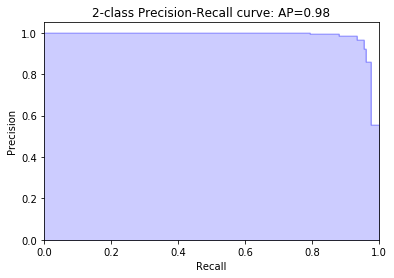

[INFO] SCORES :  [0.9896907216494846, 0.9948186528497409, 0.993103448275862, 0.9922279792746114, 0.9917184265010351, 0.9930915371329879, 0.992603550295858, 0.9909326424870466, 0.9919447640966629, 0.9906735751295337, 0.9858757062146892, 0.9861830742659758, 0.9888446215139443, 0.9888971132494448, 0.9861878453038674, 0.9727979274611399, 0.9792809262644728, 0.9643062751871042, 0.9574700109051254]
[INFO] MEAN =  0.9858236209504521
[INFO] MAX =  0.9948186528497409


(GradientBoostingClassifier(criterion='friedman_mse', init=None,
                            learning_rate=0.1, loss='deviance', max_depth=5,
                            max_features=None, max_leaf_nodes=None,
                            min_impurity_decrease=0.0, min_impurity_split=None,
                            min_samples_leaf=1, min_samples_split=2,
                            min_weight_fraction_leaf=0.0, n_estimators=100,
                            n_iter_no_change=None, presort='auto',
                            random_state=None, subsample=1.0, tol=0.0001,
                            validation_fraction=0.1, verbose=0,
                            warm_start=False),
       systemic_crisis      exch_usd  domestic_debt_in_default  \
 1036                0  5.040000e-26                         0   
 797                 0  2.536011e+00                         0   
 544                 0  1.313670e+01                         0   
 413                 0  2.000000e+00             

In [53]:
trainAndScorePrecisionRecall(model, X, y)

## XGBClassifier

In [54]:
from xgboost import XGBClassifier
model = XGBClassifier()
trainAndScore(model, X, y)

[INFO] SCORES :  [0.9896907216494846, 0.9896373056994818, 0.9689655172413794, 0.9740932642487047, 0.979296066252588, 0.9827288428324698, 0.9837278106508875, 0.9831606217616581, 0.9827387802071347, 0.983419689119171, 0.980225988700565, 0.9810017271157168, 0.9832669322709163, 0.9807549962990377, 0.981353591160221, 0.9818652849740933, 0.9823278488726387, 0.9786989061600461, 0.9498364231188658]
[INFO] MEAN =  0.9798310693860558
[INFO] MAX =  0.9896907216494846


## Random Forest Classifier

In [55]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 20)
trainAndScore(model, X, y)

[INFO] SCORES :  [0.9896907216494846, 0.9948186528497409, 0.993103448275862, 0.9922279792746114, 0.9917184265010351, 0.9948186528497409, 0.992603550295858, 0.9883419689119171, 0.9861910241657077, 0.9875647668393782, 0.9830508474576272, 0.9835924006908463, 0.9848605577689243, 0.9866765358993338, 0.9820441988950276, 0.9753886010362695, 0.9804996953077392, 0.9637305699481865, 0.950381679389313]
[INFO] MEAN =  0.9842791725266633
[INFO] MAX =  0.9948186528497409


> We can see that with 20 trees the model have a tendancy to overfit the data

### Let's do a GridSearch with Cross-Validation to find the best parameters to fine tune our Model

In [56]:
from sklearn.model_selection import GridSearchCV

rfc = RandomForestClassifier(n_estimators=60) 

param_grid = { 
    'n_estimators': [40, 120],
    'max_depth' : [1, 15],
}

CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X, y)
print(CV_rfc.best_params_)

{'max_depth': 1, 'n_estimators': 120}


In [59]:
model = RandomForestClassifier(n_estimators = 120, max_depth = 1)
trainAndScore(model, X, y)

[INFO] SCORES :  [0.8865979381443299, 0.9326424870466321, 0.8931034482758621, 0.9067357512953368, 0.9192546583850931, 0.8946459412780656, 0.9171597633136095, 0.9067357512953368, 0.9228998849252014, 0.9233160621761658, 0.9199623352165726, 0.9145077720207254, 0.9171314741035856, 0.9111769059955589, 0.919889502762431, 0.9449481865284974, 0.9250457038391224, 0.7973517559009787, 0.806979280261723]
[INFO] MEAN =  0.9031623475139382
[INFO] MAX =  0.9449481865284974


## K-Nearest Neighbors

In [68]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=40) 
trainAndScore(model, X, y)

[INFO] SCORES :  [0.8969072164948454, 0.927461139896373, 0.896551724137931, 0.8937823834196891, 0.8799171842650103, 0.8652849740932642, 0.8668639053254438, 0.8795336787564767, 0.8906789413118527, 0.8497409326424871, 0.8531073446327684, 0.8497409326424871, 0.8430278884462151, 0.8112509252405625, 0.819060773480663, 0.7959844559585493, 0.7062766605728215, 0.7109959700633276, 0.4940021810250818]
[INFO] MEAN =  0.8279036427582026
[INFO] MAX =  0.927461139896373
